# __3945 HW3__
### Student 1: Yarden Fogel
### Student 2: Roni Ben Dom

### Imports

In [1]:
# general imports 
import os, io, platform, math 
import numexpr as ne
import urllib.request
import logging 
import matplotlib.pyplot as plt
from PIL import Image
from bs4 import BeautifulSoup
import requests
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# torch & scikit
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from sklearn.linear_model import Lasso
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage import img_as_float


In [2]:
seed=7
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# setting device to use M2 GPU (MPS)
has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
 
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"
 
print(f"Python Platform: {platform.platform()}") #Python Platform: macOS-13.4-arm64-arm-64bit
# print(f"PyTorch Version: {torch.__version__}") #PyTorch Version: 2.0.1
  
print("GPU is", "available" if has_gpu else "NOT AVAILABLE") #GPU is NOT AVAILABLE
print("MPS is", "AVAILABLE" if has_mps else "NOT AVAILABLE") #MPS is AVAILABLE
 
print(f"Target device is {device}") #Target device is mps

torch.set_default_device('mps')

Python Platform: macOS-13.4.1-arm64-arm-64bit
GPU is NOT AVAILABLE
MPS is AVAILABLE
Target device is mps


## Helper functions

In [4]:
def transform(img):
    transform_im_for_model = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

    transform_im_for_model_np = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                ])

    if type(img) == np.ndarray:
        return transform_im_for_model_np(img.astype(np.uint8))
    else:
        return transform_im_for_model(img)

In [5]:
def normalize_image(orig_image):
    return (orig_image - orig_image.min()) / (orig_image.max() - orig_image.min())

## Part 0

### Getting pretrained model $f$

In [6]:
model = models.efficientnet_v2_m(pretrained=True)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

### Download images, imagenet classes

In [7]:
# create image directory
image_dir = "images"

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def download_image_from_url(url, index):
    """
    Downloads an image from the specified URL and saves it locally. Using unsplashed for beautiful free HD pics

    :param url: URL of the image to download.
    :type url: str
    """

    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the response
        soup = BeautifulSoup(response.content, "html.parser")

        if image_element := soup.find("meta", property="og:image"):
            image_url = image_element["content"]

            image_response = requests.get(image_url) # now GET to image url 

            # Check request success for image 
            if image_response.status_code == 200:
                # timestamp = int(time.time()) # generate timestamp 
                filename = f'images/image_{index}.jpg' # tag image filename w timestamp

                with open(filename, "wb") as f: 
                    f.write(image_response.content) # save image locally

                logger.info("Image downloaded successfully as '%s'🤓", filename) # success log per image
            else:
                logger.error("Failed to download image.")
        
        else:
            logger.error("Image url not found.")
    
    else:
        logger.error("Failed to retrieve page 😱")


### Downloading Images & ImageNet Class Labels

In [8]:
Path(image_dir).mkdir(exist_ok=True, parents=True)

kid_url = 'https://unsplash.com/photos/11GZVrMzfUU'
dog_url = 'https://unsplash.com/photos/-BP9geCQAV0'
cat_url = 'https://unsplash.com/photos/mJaD10XeD7w'
download_image_from_url (kid_url, 1)
download_image_from_url (dog_url, 2)
download_image_from_url (cat_url, 3)

INFO:__main__:Image downloaded successfully as 'images/image_1.jpg'🤓
INFO:__main__:Image downloaded successfully as 'images/image_2.jpg'🤓
INFO:__main__:Image downloaded successfully as 'images/image_3.jpg'🤓


In [9]:
image_paths = [f'{image_dir}/image_1.jpg', f'{image_dir}/image_2.jpg', f'{image_dir}/image_3.jpg']
kid_img = Image.open(image_paths[0])
dog_img = Image.open(image_paths[1])
cat_img = Image.open(image_paths[2])

images = [kid_img, dog_img, cat_img]

In [10]:
transformed_images_np = [transform(img) for img in images]
transformed_images_np = [img.squeeze().permute(1, 2, 0).to("cpu").numpy() for img in transformed_images_np]

In [11]:
# Downloading ImageNet class labels
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
filename = "imagenet_classes.txt"
urllib.request.urlretrieve(url, filename)

print('ImageNet class labels downloaded successfully')

with open(filename, "r") as f:
    class_names = [line.strip() for line in f.readlines()]

ImageNet class labels downloaded successfully


## Part 1

In [12]:
class PredictImage():
    def __init__(self, class_names):
        self.class_names = class_names

    def predict(self, img, k, _print, plot):
        im = transform(img)
        im = im.unsqueeze(0)
        im = im.to('mps') # sending to GPU device to match output 
        with torch.no_grad():
            outputs = model(im)
        _, predicted_indices = torch.topk(outputs, k=k)
        predicted_indices = predicted_indices.squeeze().tolist()

        if k > 1:
            predicted_classes = []
            if _print:
                print(f'Top {k} predicted classes:')
            for index in predicted_indices:
                predicted_classes.append(self.class_names[index])
                if _print:
                    print(self.class_names[index])
        else:
            predicted_classes = self.class_names[predicted_indices]
            if _print:
                print(f'Top predicted class:\n{predicted_classes}')

        scores = outputs[:, predicted_indices].to("cpu").numpy()[0]

        if plot:
            plt.figure(figsize=(8,12))
            plt.imshow(img)
            plt.title(self.class_names[predicted_indices[0]])
            plt.show()

        return predicted_classes, predicted_indices, scores #Return k top classes

### Visualize Images and Top 3 Predictions:

Top 3 predicted classes:
"cowboy hat",
"sombrero",
"cowboy boot",


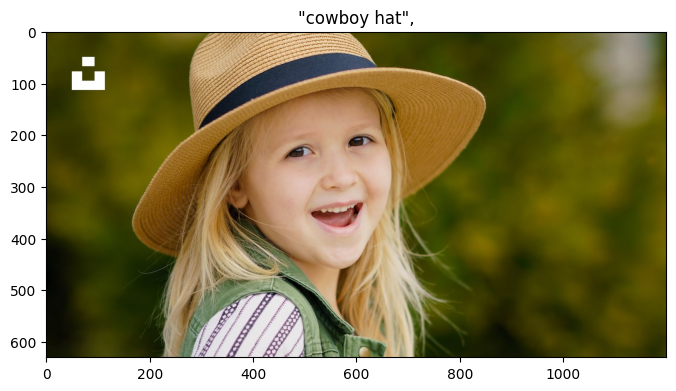

Top 3 predicted classes:
"collie",
"Shetland Sheepdog",
"Border Collie",


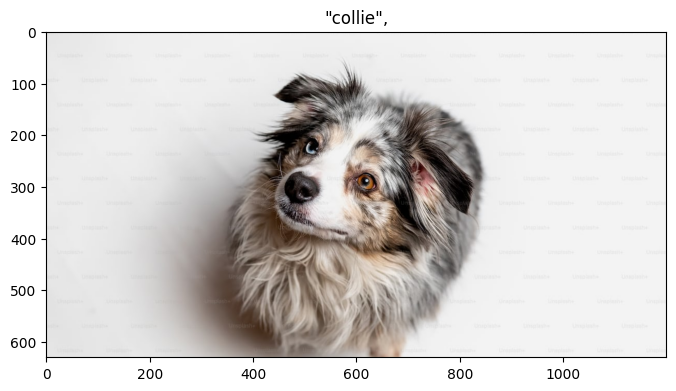

Top 3 predicted classes:
"tabby cat",
"tiger cat",
"Egyptian Mau",


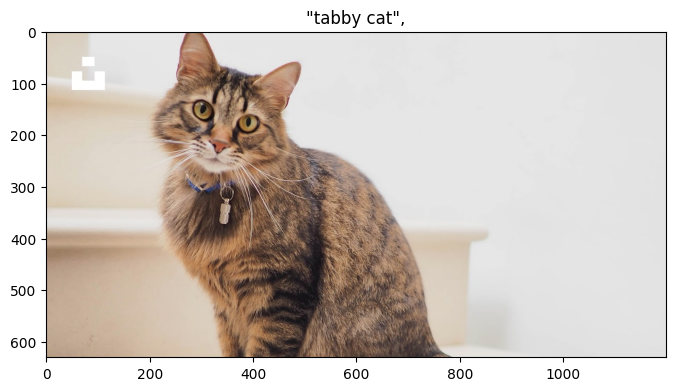

In [13]:
k = 3 # Number of top predictions to return
image_predictor = PredictImage(class_names)
predicted_classes = []

for img in images:
    classes , _, _ = image_predictor.predict(img, k, _print = True, plot = True)
    predicted_classes.append(classes)

### Super Pixels + Pertubations Class:

In [14]:
class SuperPixels:
    def __init__(self, image, num_segments, show_boundries = False):
        self.orig_image = image
        self.transformed_image = transform(image)
        self.np_image = self.transformed_image.squeeze().permute(1, 2, 0).to("cpu").numpy()
        # self.np_image = np.array(self.orig_image)
        self.num_segments = num_segments
        self.segments = slic(self.np_image, n_segments = self.num_segments) - 1
        self.actual_num_segments = len(np.unique(self.segments))

        if show_boundries:
            fig = plt.figure("Superpixels -- %d segments" % (self.num_segments))
            ax = fig.add_subplot(1, 1, 1)
            ax.imshow(mark_boundaries(normalize_image(self.np_image), self.segments))
            plt.axis("off")
            plt.show()

    def generate_perturbation(self, plot):
        perturbation = np.random.randint(2, size=self.actual_num_segments)
        include_pixels = np.where(perturbation == 1)[0]
        mask = np.zeros(self.np_image.shape)
        for i in range(len(mask)):
            for j in range(len(mask[0])):
                if self.segments[i][j] in include_pixels:
                    mask[i, j, :] = 1
        if plot:
            plt.imshow(np.multiply(normalize_image(self.np_image), mask))
            plt.title("Perturbed Instance", y=1.02)
            plt.show()

        return np.multiply(self.np_image, mask), perturbation

    def get_segments(self):
        return self.segments


In [15]:
num_regions = 100

kid_super_pixels = SuperPixels(kid_img, num_regions)
dog_super_pixels = SuperPixels(dog_img, num_regions)
cat_super_pixels = SuperPixels(cat_img, num_regions)

super_pixels = [kid_super_pixels, dog_super_pixels, cat_super_pixels]

In [16]:
class CreateLocalDatasetAndFit():
    def __init__(self, predictor, dataset_size, sigma, lasso_alpha):
        self.predictor = predictor
        self.dataset_size = dataset_size
        self.sigma_squared = sigma ** 2
        self.lasso_alpha = lasso_alpha

    def fit(self, orig_image, super_pixel_image, orig_predicted_classes):
        fig, ax = plt.subplots(1, len(orig_predicted_classes), figsize = (12, 6))
        for i, _class in enumerate(orig_predicted_classes):
            images, perturbations, labels, similarities = self.create_dataset(orig_image, super_pixel_image, _class)
            lasso = Lasso(alpha = self.lasso_alpha)
            lasso.fit(X = perturbations, y = labels, sample_weight = similarities)
            
            top_superpixels = np.argwhere(lasso.coef_ > 0)
            segments = super_pixel_image.get_segments()

            mask = np.isin(segments, top_superpixels)

            norm_image = normalize_image(orig_image)

            img_boundary = mark_boundaries(norm_image, mask, color=(0, 0, 0), outline_color=(0.8, 0.8, 0.8), )

            rgba = np.zeros(shape=norm_image.shape[:2])
            filter_image = np.dstack([norm_image, rgba])
            filter_image[~mask] = np.array([0, 0, 0, 0], dtype=float)
            filter_image[mask] = np.array([44/255, 160/255, 44/255, 0.5], dtype=float)
            
            ax[i].imshow(img_boundary)
            ax[i].imshow(filter_image)
            ax[i].set_title(f'{_class}', y=1.02)
        plt.show()  
                        

    def calc_similarity(self, orig_img, perturbed_img, sigma):
        eucl_dist = np.sum((orig_img - perturbed_img) ** 2)
        exp = -((eucl_dist / self.sigma_squared))
        return np.exp(exp)
                

    def create_dataset(self, orig_image, super_pixel_image, orig_predicted_class):
        images = []
        perturbations = []
        labels = []
        similarities = []
        for i in range(self.dataset_size):
            perturbed_img, perturbation = super_pixel_image.generate_perturbation(plot = False)
            label, _, score = self.predictor.predict(perturbed_img, 1, _print = False, plot = False)
            similarity = self.calc_similarity(orig_image, perturbed_img, self.sigma_squared)

            images.append(perturbed_img)
            perturbations.append(perturbation)
            labels.append(score)
            similarities.append(similarity)
        
        return images, perturbations, labels, similarities

In [17]:
num_pertrubations = 500
sigma = 1e5
lasso_alpha = 0.05

model_1 = CreateLocalDatasetAndFit(image_predictor, num_pertrubations, sigma, lasso_alpha)
for orig_img, super_pixels_img, classes in zip(transformed_images_np, super_pixels, predicted_classes):
    model_1.fit(orig_img, super_pixels_img, classes)